## Kymograph Cluster Code

In [1]:
import trenchripper as tr

#### Start Dask

In [2]:
kymo_controller = tr.cluster.dask_controller(walltime='04:00:00',local=False,n_workers=40,memory='2GB')
kymo_controller.startdask()
kymo_controller.daskcluster.start_workers()

In [16]:
kymo_controller.daskclient

Client Scheduler: tcp://10.120.16.188:50722 Dashboard: http://10.120.16.188:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


#### Perform Extraction

In [4]:
hdf5_extractor = tr.ndextract.hdf5_fov_extractor("/n/scratch2/de64/for_sylvia/2019-02-08_bacillus_bDE6_bDE7_bDE8_timelapse.nd2","/n/scratch2/de64/for_sylvia/timelapse/hdf5",num_cols=40) ##find a more elegent way to do grids....

/home/de64/anaconda3/envs/mothermachine/lib/python3.6/site-packages/nd2reader/common_raw_metadata.py:94: RuntimeWarning: Reported average frame interval (300004.9 ms) doesn't match the set interval (300000.0 ms). Using the average now.
  warnings.warn(message % (avg_interval, interval), RuntimeWarning)


In [15]:
hdf5_extractor.writemetadata()

In [16]:
fov_list = list(range(hdf5_extractor.num_fovs))
# fov_list = list(range(16)) + list(range(29,40))

In [17]:
kymo_controller.mapfovs(hdf5_extractor.extract_fov,fov_list)

In [ ]:
# props = kymo_controller.daskclient.gather(kymo_controller.futures) #this will hang until all futures are done

In [1]:
# hdf5_extractor.extract_fov(0)

#### End Dask, Cancel Jobs

In [31]:
kymo_controller.shutdown()

In [ ]:
#scancel --name=dask-worker --user=de64

#### Generate Kymographs

#### Start Dask

In [2]:
kymo_controller = tr.cluster.dask_controller(walltime='04:00:00',local=False,n_workers=40,memory='4GB')
kymo_controller.startdask()
kymo_controller.daskcluster.start_workers()

In [3]:
kymo_controller.daskclient

Client Scheduler: tcp://10.120.16.178:51965 Dashboard: http://10.120.16.178:8787/status,Cluster Workers: 2 Cores: 2 Memory: 8.00 GB


In [14]:
input_file_prefix = '/n/scratch2/de64/for_sylvia/timelapse/hdf5/fov_'
output_path = '/n/scratch2/de64/for_sylvia/timelapse/kymo'
all_channels = ["channel_Phase"]

kymo = tr.kymograph.kychunker(input_file_prefix=input_file_prefix,output_path=output_path,all_channels=all_channels,trench_len_y=110,padding_y=20,trench_width_x=20,\
                 t_chunk=10,t_range=(0,20),y_percentile=90,y_min_edge_dist=50,smoothing_kernel_y=(17,1),triangle_nbins=50,triangle_scaling=1.2,\
                 top_orientation=0,x_percentile=85,background_kernel_x=(301,1),smoothing_kernel_x=(9,1),otsu_nbins=50,otsu_scaling=0.7)

In [4]:
hdf5_extractor.metadata['channels'] ##these names should match my convention

NameError: name 'hdf5_extractor' is not defined

In [5]:
fov_list = list(range(15)) + list(range(67,80))

In [6]:
kymo_controller.mapfovs(kymo.generate_kymograph,fov_list)

maybe an estimate of memory usage

In [3]:
import numpy as np

In [15]:
kymo.generate_kymograph(15) ## figure out this error ##

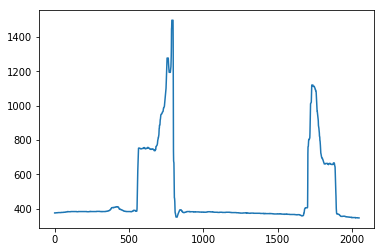

In [5]:
from matplotlib import pyplot as plt
plt.plot(output[0]["data"][:,0])

### NOTE

- **How to deal with some fovs having a different number of rows than other fovs??? Try to make more flexible...**

maybe add a kymograph viewer here

### Note
There may be an issue where hdf5 files do not close properly on crashes...

In [7]:
# props = kymo_controller.daskclient.gather(kymo_controller.futures) #this will hang until all futures are done

#### End Dask, Cancel Jobs

In [7]:
kymo_controller.shutdown()

In [ ]:
#scancel --name=dask-worker --user=de64

#### Note: access request to the transfer partition pending; automate this bit later

In [10]:
import subprocess

in_path = "/n/files/SysBio/PAULSSON LAB/Daniel/Image_Data/test"
out_path = "/n/scratch2/de64/for_sylvia/"
wrap_str = "rsync " + in_path + " " + out_path
cmd_str = 'sbatch -p transfer -t 0-12:00 --wrap="' + wrap_str + '"'

subprocess.check_output(cmd_str,
                shell=True)

CalledProcessError: Command 'sbatch -p transfer -t 0-12:00 --wrap="rsync /n/files/SysBio/PAULSSON LAB/Daniel/Image_Data/test /n/scratch2/de64/for_sylvia/"' returned non-zero exit status 1.

In [6]:
cmd_str

'sbatch -p transfer -t 0-12:00 --wrap="rsync /n/files/SysBio/PAULSSON LAB/Daniel/Image_Data/2019-02-08_bacillus_mbm_top_s750_bottom /n/scratch2/de64/for_sylvia/"'

In [11]:
!sbatch -p transfer -t 0-12:00 --wrap="rsync /n/files/SysBio/PAULSSON\LAB/Daniel/Image_Data/Bacillus_Project/test /n/scratch2/de64/for_sylvia/"

sbatch: error: Batch job submission failed: User's group not permitted to use this partition


#### Note: need to find a way to associate lanes from init barcoding snapshot with imaging lanes

plan:
- extract and segment (with phase) barcoding file
- extract and segment experiemnt file
- for both, note x positions of t=0 trenches
- compare these values to map trenches to eachother...

In [4]:
import h5py
from matplotlib import pyplot as plt
import numpy as np

In [5]:
np.array([1,2])[:]

array([1, 2])

In [16]:
h5py_handle = h5py.File("/n/scratch2/de64/for_sylvia/timelapse/kymo/kymo_15.hdf5","r")

In [17]:
list(h5py_handle.keys())

['0']

In [19]:
top = h5py_handle["0/channel_Phase"]

In [20]:
# top = h5py_handle["channel_Phase"]

In [21]:
top

<HDF5 dataset "channel_Phase": shape (83, 130, 20, 20), type "<u2">

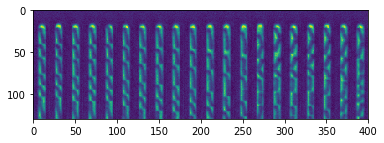

In [22]:
# plt.imshow(top[50,:,:,20])
tr.tplot.plot_kymograph(top[10,:,:,0:500])

In [25]:
def test_fn():
    h5py_handle = h5py.File("/n/scratch2/de64/for_sylvia/timelapse/hdf5/fov_0.hdf5","r");
    top = h5py_handle["channel_Phase"];
    test = top[:,:,0:50];
    output2 = np.percentile(test,85,axis=1,interpolation='lower');
    output3 = np.percentile(test,85,axis=1,interpolation='higher');
    output4 = np.percentile(test,85,axis=1,interpolation='linear');
    h5py_handle.close()

In [26]:
%load_ext line_profiler
%lprun -f test_fn test_fn()

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


Timer unit: 1e-06 s

Total time: 39.6359 s
File: <ipython-input-25-1a56ceeb7df0>
Function: test_fn at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def test_fn():
     2         1       3147.0   3147.0      0.0      h5py_handle = h5py.File("/n/scratch2/de64/for_sylvia/timelapse/hdf5/fov_0.hdf5","r");
     3         1        481.0    481.0      0.0      top = h5py_handle["channel_Phase"];
     4         1   20586913.0 20586913.0     51.9      test = top[:,:,0:50];
     5         1    5080581.0 5080581.0     12.8      output2 = np.percentile(test,85,axis=1,interpolation='lower');
     6         1    5942326.0 5942326.0     15.0      output3 = np.percentile(test,85,axis=1,interpolation='higher');
     7         1    8021980.0 8021980.0     20.2      output4 = np.percentile(test,85,axis=1,interpolation='linear');
     8         1        447.0    447.0      0.0      h5py_handle.close()

AttributeError: 'Dataset' object has no attribute 'index'

In [21]:
h5py_handle = h5py.File("/n/scratch2/de64/for_sylvia/timelapse/hdf5/fov_0.hdf5","r");
top = h5py_handle["channel_Phase"];
slc = [slice(None)] * len(top.shape)
slc[2] = slice(0, 50)
print(slc)
test = top[tuple(slc)];
h5py_handle.close()

[slice(None, None, None), slice(None, None, None), slice(0, 50, None)]


In [22]:
h5py_handle = h5py.File("/n/scratch2/de64/for_sylvia/timelapse/hdf5/fov_0.hdf5","r");
top = h5py_handle["channel_Phase"];
test = top[:,:,range(0,50)];
h5py_handle.close()

In [73]:
h5py_handle = h5py.File("/n/scratch2/de64/for_sylvia/timelapse/hdf5/fov_0.hdf5","r");
top = h5py_handle["channel_Phase"];
test = top[:,:,list(range(0,50))];
h5py_handle.close()

In [ ]:
h5py_handle = h5py.File("/n/scratch2/de64/for_sylvia/timelapse/hdf5/fov_0.hdf5","r");
top = h5py_handle["channel_Phase"];
test = np.take(top, list(range(0,50)), axis=2)
h5py_handle.close()

In [ ]:
np.take(h5py_handle["channel_Phase"], [1,2,3,4,5], axis=2) ##this operation is killing me

In [9]:
h5py_handle["channel_Phase"][:,:,:20].shape

(2048, 2048, 20)

In [4]:
h5py_handle.close()

In [8]:
h5py_handle["1/channel_YFP"]

<HDF5 dataset "channel_YFP": shape (85, 160, 20, 1), type "<u2">

In [12]:
h5py_handle.close()

In [39]:
testlist = ["success"]
potato = "fail"

In [43]:
def test(potato, testlist):
    exec("potato = testlist")
    return potato

In [44]:
test(potato,["moo"])

'fail'

In [45]:
potato

'fail'

In [5]:
h5py_handle = h5py.File("/n/scratch2/de64/for_sylvia/timelapse/hdf5/fov_0.hdf5","r")

In [6]:
h5py_handle["channel_Phase"].chunks

(256, 256, 1)

In [7]:
h5py_handle["channel_Phase"]

<HDF5 dataset "channel_Phase": shape (2048, 2048, 648), type "<u2">

In [32]:
target[slc]

/home/de64/anaconda3/envs/mothermachine/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


array([[[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]]])